In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module, which can be installed with a simple:



In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc

Requirement already up-to-date: CFEDemands in /opt/conda/lib/python3.8/site-packages (0.2.7)


The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet can be found at
[https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/](https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/).

This spreadsheet consists of two worksheets, labeled &ldquo;Expenditures&rdquo;
and &ldquo;Household Characteristics&rdquo;, respectively.

Each worksheet has the initial three columns labeled &ldquo;j&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;j&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (j,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet should
have one column for each category of expenditures (e.g., &ldquo;Rice&rdquo;, &ldquo;Goat
meat&rdquo;, &ldquo;Millet&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in the ICRISAT data:
namely numbers of &ldquo;Men&rdquo;, &ldquo;Women&rdquo;, &ldquo;Boys&rdquo; and &ldquo;Girls&rdquo;; also the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



We begin by defining a dictionary that contains the spreadsheet key. 
One is provided for the Indian ICRISAT example that I wish to work
through.



In [4]:
#https://docs.google.com/spreadsheets/d/1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk/edit#gid=1201583718

In [5]:
uganda_data = '1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk'

In [6]:
uganda_data

'1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk'

With the spreadsheet defined , grab it and define a couple of
dataframes. Note that the spreadsheet must be public for this approach
to work; if you want to keep this private consider using private
keys.



In [10]:
!pip install oauth2client

  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)


In [48]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../Project2/')
from eep153_tools import read_sheets

#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ../students-9093fa174318.json.gpg > ../students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
x = read_sheets(uganda_data,sheet='Expenditures',json_creds='../students-9093fa174318.json')
                 
# Change 'ICRISAT' to key of your own sheet in Sheets, above
z = read_sheets(uganda_data,sheet="HH Characteristics",json_creds='../students-9093fa174318.json')

# Assume a single market: (Comment this out to make each village its own market)
z['m'] = 1
x['m'] = 1


x = x.replace("NaN",np.nan) # Replace zeros with missing
x = x.replace("0",np.nan)

x = x.astype(float)



# Take logs of expenditures; call this y
y = np.log(x.set_index(['j','t','m']))

z.set_index(['j','t','m'],inplace=True)

#x.apply(pd.to_numeric, errors='ignore')



gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


This gives a dataframe of household characteristics $z$ with a simple structure.



In [49]:
z.head()

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+
j,t,m,,,,,,,,,,,,,,
1013000201,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1013000202,2005,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1013000204,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1013000206,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1013000209,2005,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [81]:


z["Family Size"] = z["M 0-3"] + z["M 4-8"] + z["M 9-13"] + z["M 14-18"] + z["M 19-30"] + z["M 31-50"]+ z["M 51+"] + z["F 0-3"] + z["F 4-8"] + z["F 9-13"] + z["F 14-18"] + z["F 19-30"] + z["F 31-50"]+ z["F 51+"]



In [124]:


with_children_df  = pd.concat([z[z["M 0-3"] >0], z[z["M 4-8"] >0], z[z["M 9-13"] >0], z[z["M 14-18"] >0], z[z["F 0-3"] >0], z[z["F 4-8"] >0], z[z["F 9-13"] >0], z[z["F 14-18"] >0]]).drop_duplicates()


with_children_id = with_children.reset_index()["j"]



In [125]:
without_children_df = z.drop(with_children_df.index)

without_children_id = without_children_df.reset_index()["j"]



len(with_children_df)

6528

In [126]:
len(without_children_id)

5134

In [127]:
len(with_children_df) +len(without_children_id)

11662

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [51]:
y.head()

Matooke(cluster)  Matooke(others)  avocado  \
j            t      m                                                 
1.013000e+09 2005.0 1.0               NaN              NaN      NaN   
                    1.0               NaN              NaN      NaN   
                    1.0               NaN              NaN      NaN   
                    1.0               NaN              NaN      NaN   
                    1.0               NaN              NaN      NaN   

                         beans dry  beans fresh      beef       beer  bread  \
j            t      m                                                         
1.013000e+09 2005.0 1.0        NaN          NaN  8.699515   7.783224    NaN   
                    1.0        NaN          NaN       NaN        NaN    NaN   
                    1.0        NaN          NaN       NaN        NaN    NaN   
                    1.0        NaN          NaN       NaN        NaN    NaN   
                    1.0        NaN          NaN       NaN  10.150348    NaN   

                         cabbages  carrots  ...  simsim      soda  sorghum  \
j            t      m                       ...                              
1.013000e+09 2005.0 1.0       NaN      NaN  ...     NaN       NaN      NaN   
                    1.0       NaN      NaN  ...     NaN       NaN      NaN   
                    1.0       NaN      NaN  ...     NaN       NaN      NaN   
                    1.0       NaN      NaN  ...     NaN       NaN      NaN   
                    1.0       NaN      NaN  ...     NaN  8.517193      NaN   

                            sugar  sweet bananas  sweet potatoes dry  \
j            t      m                                                  
1.013000e+09 2005.0 1.0  8.411833            NaN                 NaN   
                    1.0       NaN            NaN                 NaN   
                    1.0       NaN            NaN                 NaN   
                    1.0       NaN            NaN                 NaN   
                    1.0  7.600902            NaN                 NaN   

                         sweet potatoes fresh       tea  tomatoes  watermelon  
j            t      m                                                          
1.013000e+09 2005.0 1.0                   NaN  3.912023  6.551080         NaN  
                    1.0                   NaN       NaN       NaN         NaN  
                    1.0                   NaN       NaN       NaN         NaN  
                    1.0                   NaN       NaN       NaN         NaN  
                    1.0              8.517193  4.605170  5.298317         NaN  

[5 rows x 74 columns]

## Estimation



With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [52]:
import cfe

result = cfe.Result(y=y,z=z)

This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [53]:
result

<xarray.Result>
Dimensions:           (i: 37, j: 3737, k: 14, m: 1, t: 4)
Coordinates:
  * j                 (j) float64 1.013e+09 1.013e+09 ... 3.03e+15 3.021e+16
  * m                 (m) float64 1.0
  * t                 (t) float64 2.005e+03 2.009e+03 2.01e+03 2.011e+03
  * i                 (i) <U34 'beans dry' 'beans fresh' ... 'tea' 'tomatoes'
  * k                 (k) <U7 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 31-50' 'F 51+'
Data variables:
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    loglambdas        object None
    a                 object None
    yhat              object None
    ce                object None
    cehat             object None
    e                 object None
    delta_covariance  object None
    beta_covariance   object None
    se_delta          object None
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes:
    firstround:            2005.0
    min_proportion_items:  0.125
    min_xproducts:         30
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    verbose:               False

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [54]:
result.get_reduced_form()

After running this we can examine the estimated coefficients $\delta$:



In [55]:
result.delta.to_dataframe().unstack('k')

delta                                \
k                                      F 0-3   F 14-18   F 19-30   F 31-50   
i                                                                            
beans dry                           0.035235  0.133076  0.064638  0.090898   
beans fresh                         0.098333  0.124233  0.120654  0.201325   
beef                                0.004936  0.049122  0.134968  0.108337   
bread                               0.021215  0.116348  0.176450  0.131142   
cabbages                            0.038930  0.091709  0.089148  0.060416   
cassava dry/flour                   0.068200  0.019923 -0.062780  0.017033   
cassava fresh                       0.003492  0.103280  0.064463  0.154521   
chicken                            -0.003726  0.009435  0.065602  0.089813   
coffee                             -0.064571  0.130770  0.140430  0.131590   
cooking oil                        -0.030974  0.089264  0.143023  0.046393   
dodo                               -0.020738  0.074052  0.120486  0.163794   
dry/smoked fish                     0.005613  0.020688  0.088960  0.013434   
eggs                                0.008264  0.118491  0.101522  0.076805   
expenditure in restaurants on food -0.221550  0.015002  0.151885  0.023080   
fresh fish                          0.024925  0.075499  0.120322  0.041352   
fresh milk                          0.089778  0.099212  0.180005  0.090505   
goat meat                          -0.050006  0.062009  0.127635  0.005612   
ground nuts pounded                -0.065921  0.096250  0.098563  0.109459   
irish potatoes                      0.084978  0.075524  0.055754  0.057684   
maize cobs                          0.104363  0.099606  0.011820 -0.031892   
maize flour                         0.075808  0.121107  0.035413  0.070201   
mangoes                             0.058143  0.092691  0.095711  0.180878   
margarine,butter                   -0.092124 -0.016967  0.000648  0.168507   
matooke_1                           0.018800  0.141944  0.216396  0.044091   
millet                              0.135429  0.070086  0.010574  0.069105   
onions                             -0.059114  0.082456  0.164587  0.064157   
oranges                            -0.185347  0.162119  0.203292  0.107010   
other vegetables                   -0.005813  0.111691  0.065563  0.099593   
passion fruits                      0.008146  0.132052  0.184250  0.265699   
rice                                0.052494  0.069365  0.132718  0.059584   
salt                                0.037779  0.067244  0.036350  0.036872   
soda                               -0.013542  0.108745  0.154578  0.012812   
sugar                               0.033302  0.077048  0.186059  0.135880   
sweet bananas                       0.046960  0.179915  0.173887  0.165799   
sweet potatoes fresh                0.024374  0.117154  0.078123  0.092751   
tea                                -0.028303  0.052945  0.128240  0.141927   
tomatoes                           -0.002241  0.087125  0.157349  0.069505   

                                                                            \
k                                      F 4-8     F 51+    F 9-13     M 0-3   
i                                                                            
beans dry                           0.096329  0.146824  0.080202 -0.020105   
beans fresh                         0.088380  0.243703  0.046099  0.003502   
beef                                0.030322  0.055811  0.070274  0.012622   
bread                               0.048413 -0.035845  0.086589 -0.010931   
cabbages                            0.024189  0.058005  0.079683  0.014337   
cassava dry/flour                   0.078190  0.172268  0.114671  0.240597   
cassava fresh                       0.062698  0.145607  0.100125 -0.003535   
chicken                             0.008261  0.135734  0.051132  0.005440   
coffee                              0.044735  0.086108 -0.03

Also the good-time constants $a_{it}$ (this captures the effects of prices)



In [56]:
result.a.to_dataframe().unstack('i')

a                                            \
i          beans dry beans fresh      beef     bread  cabbages   
t      m                                                         
2005.0 1.0  6.664045    6.166651  7.596403  6.531700  5.987894   
2009.0 1.0  7.177776    6.660552  8.087632  7.200124  6.284722   
2010.0 1.0  7.361983    6.874905  8.165703  7.073217  6.369316   
2011.0 1.0  7.436129    7.184067  8.397829  7.388194  6.608653   

                                                                            \
i          cassava dry/flour cassava fresh   chicken    coffee cooking oil   
t      m                                                                     
2005.0 1.0          7.000972      6.561716  8.220995  4.586281    6.181261   
2009.0 1.0          7.403977      6.985613  8.733654  4.799347    6.605940   
2010.0 1.0          7.427036      6.993906  8.798743  4.734974    6.763708   
2011.0 1.0          7.770406      7.339227  9.207515  5.074747    6.940089   

            ...                                                                \
i           ... other vegetables passion fruits      rice      salt      soda   
t      m    ...                                                                 
2005.0 1.0  ...         5.622420       6.412390  6.868322  4.370730  7.055358   
2009.0 1.0  ...         6.134787       6.691317  7.375543  5.028736  7.325378   
2010.0 1.0  ...         6.100634       6.631896  7.440398  4.963925  7.503323   
2011.0 1.0  ...         6.475021       6.896860  7.743197  5.120522  7.765180   

                                                                             
i              sugar sweet bananas sweet potatoes fresh       tea  tomatoes  
t      m                                                                     
2005.0 1.0  6.854877      5.973993             6.627925  4.610117  5.958305  
2009.0 1.0  7.196572      6.407480             7.068341  4.678707  6.417172  
2010.0 1.0  7.370396      6.422730             7.447756  4.683057  6.427528  
2011.0 1.0  7.461896      6.816289             7.318681  4.936173  6.622662  

[4 rows x 37 columns]

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [57]:
result.get_beta(as_df=True)

i
beans dry                             0.255622
beans fresh                           0.381523
beef                                  0.384351
bread                                 0.568417
cabbages                              0.357247
cassava dry/flour                     0.124855
cassava fresh                         0.313435
chicken                               0.322282
coffee                                0.632619
cooking oil                           0.483203
dodo                                  0.452957
dry/smoked fish                       0.351626
eggs                                  0.420556
expenditure in restaurants on food    0.460684
fresh fish                            0.412433
fresh milk                            0.567437
goat meat                             0.360544
ground nuts pounded                   0.367467
irish potatoes                        0.388275
maize cobs                            0.356432
maize flour                           0.285216
mangoes    

In [58]:
result.get_alpha(as_df=True)

i
beans dry                             6.664045
beans fresh                           6.166651
beef                                  7.596403
bread                                 6.531700
cabbages                              5.987894
cassava dry/flour                     7.000972
cassava fresh                         6.561716
chicken                               8.220995
coffee                                4.586281
cooking oil                           6.181261
dodo                                  5.544825
dry/smoked fish                       6.631332
eggs                                  6.238671
expenditure in restaurants on food    7.874761
fresh fish                            7.076956
fresh milk                            7.007019
goat meat                             7.402044
ground nuts pounded                   6.263604
irish potatoes                        6.686252
maize cobs                            6.026852
maize flour                           6.736053
mangoes    

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



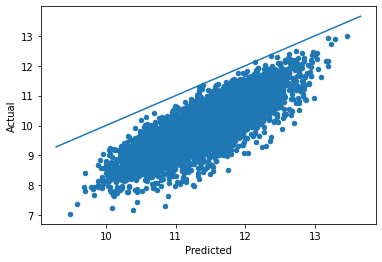

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

In [131]:
total_expend = result.get_predicted_expenditures().to_dataframe("x").unstack("i").reset_index()

In [132]:
total_expend.iloc[0]


   i                                 
j                                        1.013000e+09
t                                        2.005000e+03
m                                        1.000000e+00
x  beans dry                             1.472987e+03
   beans fresh                           1.095701e+03
   beef                                  3.901109e+03
   bread                                 1.771401e+03
   cabbages                              7.464594e+02
   cassava dry/flour                     2.134000e+03
   cassava fresh                         1.507070e+03
   chicken                               5.593858e+03
   coffee                                2.977546e+02
   cooking oil                           1.139463e+03
   dodo                                  6.549926e+02
   dry/smoked fish                       1.720691e+03
   eggs                                  1.046771e+03
   expenditure in restaurants on food    6.985186e+03
   fresh fish                            2.3

In [145]:
with_children

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Family Size
j,t,m,,,,,,,,,,,,,,,
1013000202,2005,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2
1013000210,2005,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,4
1013000213,2005,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,3
1021000113,2005,1,1,1,1,1,0,1,0,0,1,2,1,1,1,0,11
1021000203,2005,1,1,1,1,1,0,0,1,0,0,0,0,2,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233002609,2011,1,0,0,0,0,1,1,0,0,0,0,1,0,0,2,5
3183000309,2011,1,0,0,0,0,1,0,0,0,0,0,2,0,0,1,4
4171000802,2011,1,0,0,0,0,1,1,0,0,0,0,1,1,1,1,6


In [147]:
without_children_df

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Family Size
j,t,m,,,,,,,,,,,,,,,
1013000201,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1013000204,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1013000206,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1013000209,2005,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1021000103,2005,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010630003050502,2011,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3010730012030203,2011,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,3
3010730016100203,2011,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2


In [163]:
with_1 = pd.merge(with_children.reset_index()[["j"]], total_expend,  on= "j", how ="inner")

#with_1.iloc[:,[1]] = with_1.iloc[:,[1]].astype(int)


with_1

/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,j,"(t, )","(m, )","(x, beans dry)","(x, beans fresh)","(x, beef)","(x, bread)","(x, cabbages)","(x, cassava dry/flour)","(x, cassava fresh)",...,"(x, other vegetables)","(x, passion fruits)","(x, rice)","(x, salt)","(x, soda)","(x, sugar)","(x, sweet bananas)","(x, sweet potatoes fresh)","(x, tea)","(x, tomatoes)"
0,1013000202,2005.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1013000202,2009.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1013000202,2010.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1013000202,2011.0,1.0,2865.870567,2582.651925,6091.092051,2420.566399,962.155505,5227.154521,2544.359011,...,928.135348,1348.116921,3393.153953,230.313474,2513.997314,2799.874343,1332.539972,2486.876799,223.123438,989.586818
4,1013000210,2005.0,1.0,1519.823239,1152.653624,4095.435867,1862.873533,692.320791,3007.998249,1277.119565,...,587.395622,1202.691459,2254.291092,129.595835,2366.034690,2252.011938,855.053972,1703.626544,201.425133,826.892296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26107,1021001301,2011.0,1.0,7911.945612,13836.055611,28442.391113,19738.086279,2965.055676,8144.337229,6096.481608,...,3577.585234,11182.808060,14379.947568,428.215783,13469.758532,14878.699611,9934.203332,6065.078913,892.266467,5336.270358
26108,104300060303,2005.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26109,104300060303,2009.0,1.0,2838.488909,2159.495081,7621.367471,4163.219583,1113.853861,3719.613639,2290.529468,...,1418.972268,2270.186604,4189.774505,254.358832,3474.314040,3815.576232,2145.789590,2331.163346,259.819977,1727.791827
26110,104300060303,2010.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:


pd.merge(without_children_df.reset_index()[["j"]], total_expend,on="j" ,how ="inner")

/opt/conda/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,j,"(t, )","(m, )","(x, beans dry)","(x, beans fresh)","(x, beef)","(x, bread)","(x, cabbages)","(x, cassava dry/flour)","(x, cassava fresh)",...,"(x, other vegetables)","(x, passion fruits)","(x, rice)","(x, salt)","(x, soda)","(x, sugar)","(x, sweet bananas)","(x, sweet potatoes fresh)","(x, tea)","(x, tomatoes)"
0,1013000201,2005.0,1.0,1472.987145,1095.700695,3901.108816,1771.401216,746.459401,2133.999668,1507.069639,...,644.103540,1646.672235,1910.088971,111.475302,2227.389715,2196.739562,1092.645359,1358.778624,203.280249,881.544614
1,1013000201,2009.0,1.0,2920.561815,1892.901200,6345.074163,2402.315444,879.651817,5132.629034,2662.332651,...,907.987863,1366.317646,3508.274713,273.364449,2286.802837,3101.978685,1108.097072,3077.599218,213.850376,1056.601828
2,1013000201,2010.0,1.0,4188.795330,2622.467490,8174.362217,3078.335255,1246.933158,5907.600835,3317.462001,...,1097.620896,1599.206478,4335.251661,276.913516,3339.304374,4347.069735,1634.234954,4063.301017,239.673962,1324.681572
3,1013000201,2011.0,1.0,3753.288184,2984.352459,7683.857497,2702.988720,1154.706704,7752.203961,3757.999992,...,1080.855240,1532.414770,4323.433946,289.768208,3067.096947,3492.721031,1492.839084,3661.361813,254.399608,1143.677037
4,1013000201,2005.0,1.0,1472.987145,1095.700695,3901.108816,1771.401216,746.459401,2133.999668,1507.069639,...,644.103540,1646.672235,1910.088971,111.475302,2227.389715,2196.739562,1092.645359,1358.778624,203.280249,881.544614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,3010730016100203,2011.0,1.0,1999.693516,1633.394128,4783.017948,1777.644279,706.724061,3954.249349,1621.294484,...,626.722975,927.570979,2335.835852,189.306354,2558.621872,1959.004851,735.498632,1825.873015,175.544690,787.319421
20528,3030230010040204,2005.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20529,3030230010040204,2009.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20530,3030230010040204,2010.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


j       t    m            x                            \
i                                       beans dry  beans fresh         beef   
0            1013000201  2005.0  1.0  1472.987145  1095.700695  3901.108816   
1            1013000201  2009.0  1.0  2920.561815  1892.901200  6345.074163   
2            1013000201  2010.0  1.0  4188.795330  2622.467490  8174.362217   
3            1013000201  2011.0  1.0  3753.288184  2984.352459  7683.857497   
0            1013000201  2005.0  1.0  1472.987145  1095.700695  3901.108816   
...                 ...     ...  ...          ...          ...          ...   
14943  3030230010040204  2011.0  1.0          NaN          NaN          NaN   
14940  3030230010040204  2005.0  1.0          NaN          NaN          NaN   
14941  3030230010040204  2009.0  1.0          NaN          NaN          NaN   
14942  3030230010040204  2010.0  1.0          NaN          NaN          NaN   
14943  3030230010040204  2011.0  1.0          NaN          NaN          NaN   

                                                                 ...  \
i            bread     cabbages cassava dry/flour cassava fresh  ...   
0      1771.401216   746.459401       2133.999668   1507.069639  ...   
1      2402.315444   879.651817       5132.629034   2662.332651  ...   
2      3078.335255  1246.933158       5907.600835   3317.462001  ...   
3      2702.988720  1154.706704       7752.203961   3757.999992  ...   
0      1771.401216   746.459401       2133.999668   1507.069639  ...   
...            ...          ...               ...           ...  ...   
14943          NaN          NaN               NaN           NaN  ...   
14940          NaN          NaN               NaN           NaN  ...   
14941          NaN          NaN               NaN           NaN  ...   
14942          NaN          NaN               NaN           NaN  ...   
14943          NaN          NaN               NaN           NaN  ...   

                                                                             \
i     other vegetables passion fruits         rice        salt         soda   
0           644.103540    1646.672235  1910.088971  111.475302  2227.389715   
1           907.987863    1366.317646  3508.274713  273.364449  2286.802837   
2          1097.620896    1599.206478  4335.251661  276.913516  3339.304374   
3          1080.855240    1532.414770  4323.433946  289.768208  3067.096947   
0           644.103540    1646.672235  1910.088971  111.475302  2227.389715   
...                ...            ...          ...         ...          ...   
14943              NaN            NaN          NaN         NaN          NaN   
14940              NaN            NaN          NaN         NaN          NaN   
14941              NaN            NaN          NaN         NaN          NaN   
14942              NaN            NaN          NaN         NaN          NaN   
14943              NaN            NaN          NaN         NaN          NaN   

                                                                                
i            sugar sweet bananas sweet potatoes fresh         tea     tomatoes  
0      2196.739562   1092.645359          1358.778624  203.280249   881.544614  
1      3101.978685   1108.097072          3077.599218  213.850376  1056.601828  
2      4347.069735   1634.234954          4063.301017  239.673962  1324.681572  
3      3492.721031   1492.839084          3661.361813  254.399608  1143.677037  
0      2196.739562   1092.645359          1358.778624  203.280249   881.544614  
...            ...           ...                  ...         ...          ...  
14943          NaN           NaN                  NaN         NaN          NaN  
14940          NaN           NaN                  NaN         NaN          NaN  
14941          NaN           NaN                  NaN         NaN          NaN  
14942          NaN           NaN                  NaN         NaN          NaN  
14943          NaN           NaN                  NaN    

### Saving Result



You can save the estimated result, using something like



In [ ]:
result.to_dataset('icrisat.ds')